**TME ESPACES D'ECHELLES \
LAM Jean-Paul**

**MODULES ET FONCTIONS UTILES**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import time

from scipy import ndimage
from scipy.signal import convolve as conv 
from scipy.linalg import solve_banded

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def show3(U,iters,name):
    ''' show 3 images side by side with U a list of images and iters a list of numbers '''
    fig, axs = plt.subplots(1,3,figsize=(20,20))
    for i in range(3):
        axs[i].imshow(U[iters[i]],cmap='gray')
        axs[i].set_title('{}, iter {}'.format(name,iters[i]))
        
def translate(img,ox,oy):
    ''' return an image translated by 1 max wrt x and y direction '''
    n,m = img.shape
    u = np.zeros((n,m))
    if ox == 1:
        if oy == 1:
            u[:-1,:-1] = img[1:,1:]
            return u
        if oy == 0:
            u[:-1,:] = img[1:,:]
            return u
        if oy == -1:
            u[:-1,1:] = img[1:,:-1]
            return u
    if ox == -1:
        if oy == 1:
            u[1:,:-1] = img[:-1,1:]
            return u
        if oy == 0:
            u[1:,:] = img[:-1,:]
            return u
        if oy == -1:
            u[1:,1:] = img[:-1,:-1]
            return u
    if ox == 0:
        if oy == 1:
            u[:,:-1] = img[:,1:]
            return u
        if oy == 0:
            u[:,:] = img[:,:]
            return u
        if oy == -1:
            u[:,1:] = img[:,:-1]
            return u
    return img


**EX1 : SCHEMA D'EULER EXPLICITE**

Les lignes correspondent à :
      fcts à dt = 0.2 
      filtre gaussien à sigma = 0.7 
      fcts à dt = 0.3


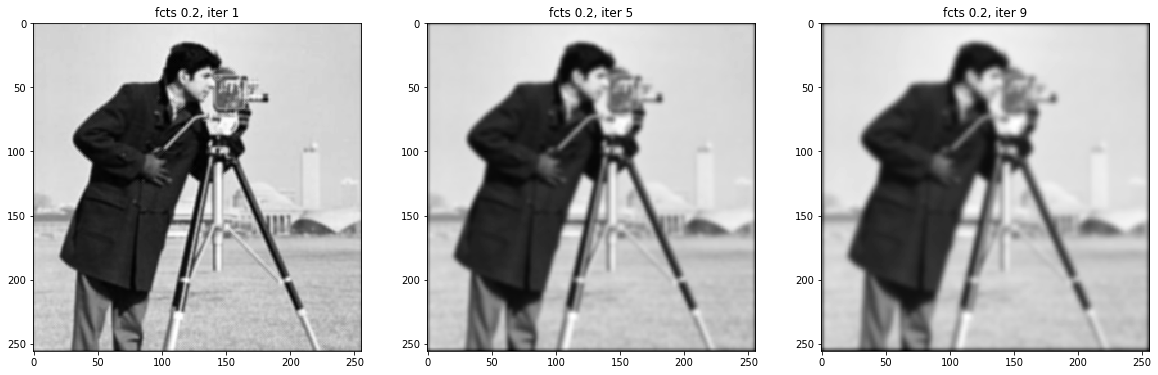

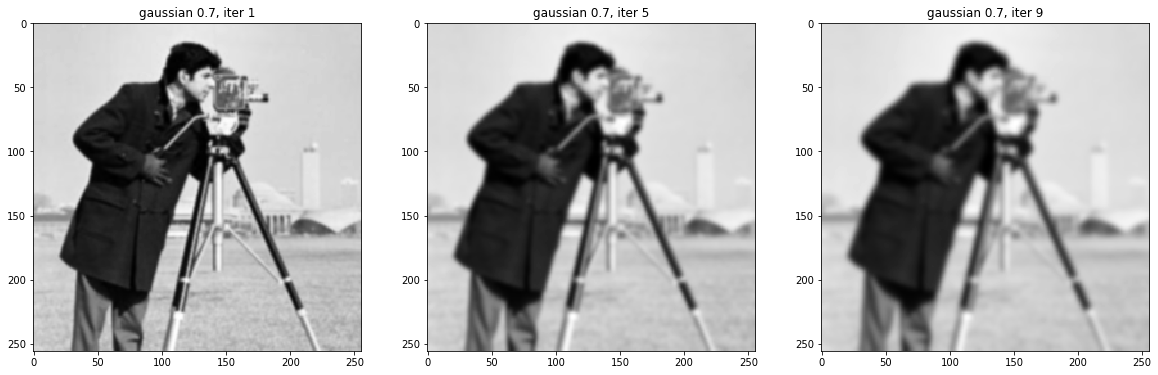

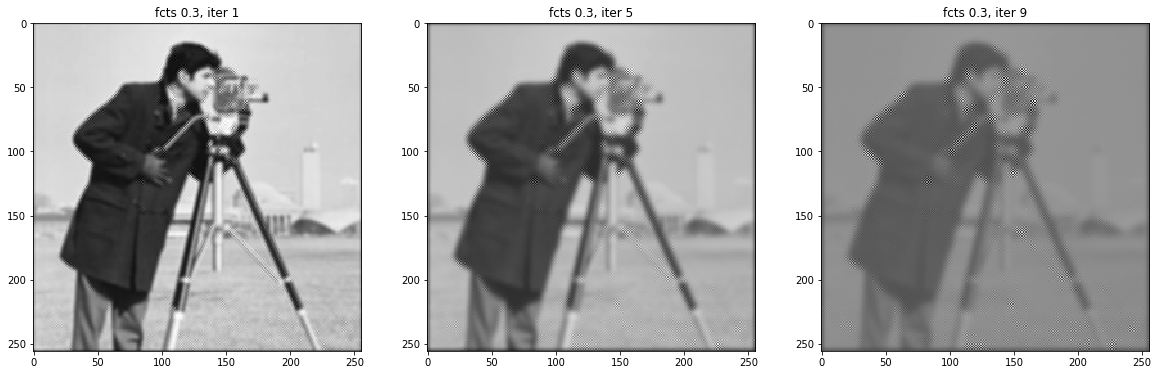

In [2]:
#image 
img = imageio.imread('cameraman.jpg').astype(float)
#img = rgb2gray(imageio.imread('synpic45657.jpg').astype(float))
#img = imageio.imread('fingerprint-small.jpg').astype(float)

#init
u_e1,u_e2,u_gauss = img,img,img
U_e1,U_e2,U_gauss = [],[],[]
ftcs = np.array([[0,1,0],[1,-4,1],[0,1,0]])

#parameters
dt1 = 0.2
dt2 = 0.3
c = 1
n_iter = 20

#compute
for i in range(n_iter):
    u_e1 = u_e1 + c * dt1 * conv(u_e1,ftcs,mode='same')
    U_e1.append(u_e1.copy())
    
    u_e2 = u_e2 + c * dt2 * conv(u_e2,ftcs,mode='same')
    U_e2.append(u_e2.copy())
    
    u_gauss = ndimage.gaussian_filter(u_gauss,0.7)
    U_gauss.append(u_gauss.copy())
    
#show
show3(U_e1,[1,5,9],'fcts 0.2')
show3(U_gauss,[1,5,9],'gaussian 0.7')
show3(U_e2,[1,5,9],'fcts 0.3')

#informations
print("""Les lignes correspondent à :
      fcts à dt = 0.2 
      filtre gaussien à sigma = 0.7 
      fcts à dt = 0.3""")  

On constate que cela revient à utiliser un filtre gaussien. \
Les zones homogènes et contours sont traités de la même manière.\
Condition CFL : 2*c*(dt/dx+dt/dy)<1 => dt<1/4 avec c=dx=dy=1 \
En augmentant le pas de temps dt à au moins 0.25 (0.3 sur les images ci-dessus), le schéma devient instable.

**EX2 : PERONA MALIK**

In [3]:
def g_tukey(x,K):
    return np.exp(-(x/K)**2)

def g_lorentz(x,K,C=1,ALPHA=1):
    return C/((1+(x/K)**(1+ALPHA)))

def compute_perona_malik(u,dt,g,K):
    #gradient in x,y with forward difference and 4 cardinal directions
    grad_x = -translate(u,-1,0) + translate(u,1,0)
    grad_y = -translate(u,0,-1) + translate(u,0,1)
    grad_N = -u + translate(u,-1,0)
    grad_W = -u + translate(u,0,-1)
    grad_E = -u + translate(u,0,1)
    grad_S = -u + translate(u,1,0)

    #applying conductivity function
    G = g(np.sqrt(grad_x**2 + grad_y**2),K)
    
    #construct G_* matrices
    G_S = translate(G,1,0)
    G_E = translate(G,0,1)
    
    #compute u at time t+1
    u = u + dt * (G*grad_N + G*grad_W + G_E*grad_E + G_S*grad_S)
    return u

def perona_malik(img,n_iter=10,dt=0.2,g=g_tukey,K=20):
    u,U = img,[]
    for i in range(n_iter):
        u = compute_perona_malik(u,dt,g,K)
        U.append(u.copy())
    return u,U
    
def compute_perona_malik_simplified(u,dt,g,K):
    #gradient in 4 cardinal directions
    grad_N = -u + translate(u,-1,0)
    grad_W = -u + translate(u,0,-1)
    grad_E = -u + translate(u,0,1)
    grad_S = -u + translate(u,1,0)
    
    #apply directly the conductivity function and compute u at time t+1
    u = u + dt * (g(grad_N,K)*grad_N + g(grad_W,K)*grad_W + g(grad_E,K)*grad_E + g(grad_S,K)*grad_S)
    return u

def perona_malik_simplified(img,n_iter=10,dt=0.2,g=g_tukey,K=20):
    u,U = img,[]
    for i in range(n_iter):
        u = compute_perona_malik_simplified(u,dt,g,K)
        U.append(u.copy())
    return u,U

In [4]:
#image
img = imageio.imread('cameraman.jpg').astype(float)
#img = rgb2gray(imageio.imread('synpic45657.jpg').astype(float))
#img = imageio.imread('fingerprint-small.jpg').astype(float)

#parameters
n_iter = 101
dt = 0.2
K = 15
g = g_tukey
C = 1
ALPHA = 1

#compute
u_pm,U_pm = perona_malik(img,n_iter,dt,g,K)
u_pms,U_pms = perona_malik_simplified(img,n_iter,dt,g,K)

K = 15, dt = 0.2, g = <function g_tukey at 0x000001E74F973D38>, 
Les lignes correspondent à :
      pm original
      pm simplifiée


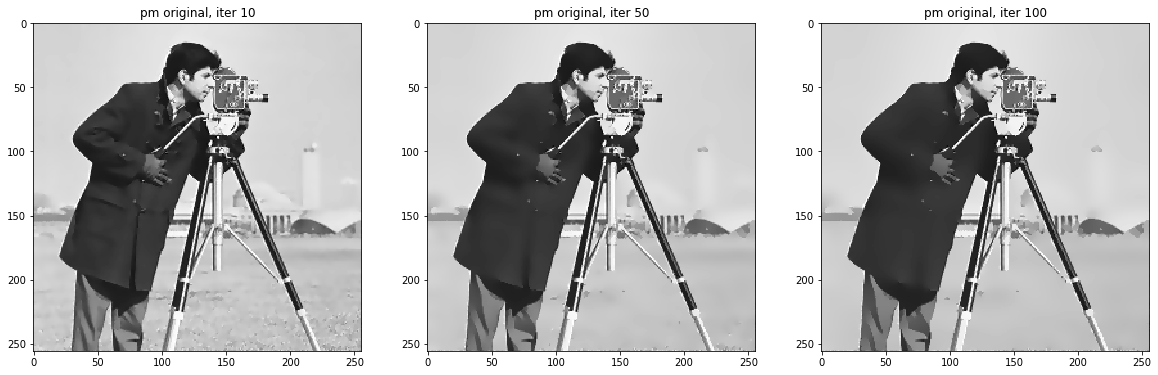

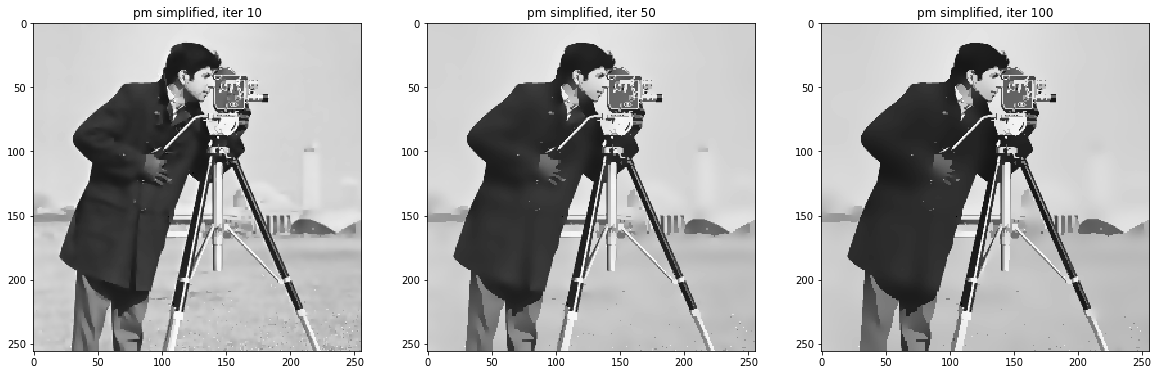

In [5]:
#show
show3(U_pm,[10,50,100],'pm original')
show3(U_pms,[10,50,100],'pm simplified')

#informations
print(f"""K = {K}, dt = {dt}, g = {g}, 
Les lignes correspondent à :
      pm original
      pm simplifiée""")

On obtient une diffusion non linéaire grâce à la fonction de conductivité. \
On a un lissage plus présent dans les zones homogènes que dans les zones de contour : 
 - x grand => g(x) faible donc pas de lissage 
 - x faible => g(x) fort donc lissage

Pour les deux versions avec les mêmes hyperparamètres, les zones homogènes sont similaires. \
La différence se trouve dans les contours/discontinuités qui sont moins nettes avec la version simplifiée. On le voit notamment (plus visible à l'itération 100) à la disparition du gratte-ciel, autour de la main ou encore la partie droite entre les deux barres du trépied ou enfin autour du jean.


**VARIATION DE K**

In [6]:
#Varying K, using lorentz for a change
g = g_lorentz
C = 1
ALPHA = 1
K1,K2,K3 = 5,20,90

#compute
u_pms1,U_pms1 = perona_malik_simplified(img,n_iter,dt,g,K1)
u_pms2,U_pms2 = perona_malik_simplified(img,n_iter,dt,g,K2)
u_pms3,U_pms3 = perona_malik_simplified(img,n_iter,dt,g,K3)
    

 Les lignes correspondent à :
      K1 = 5
      K2 = 20
      K3 = 90


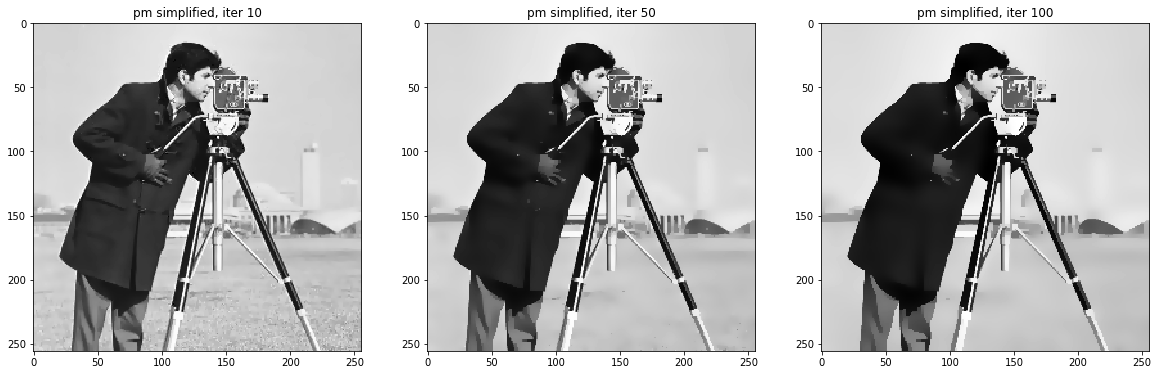

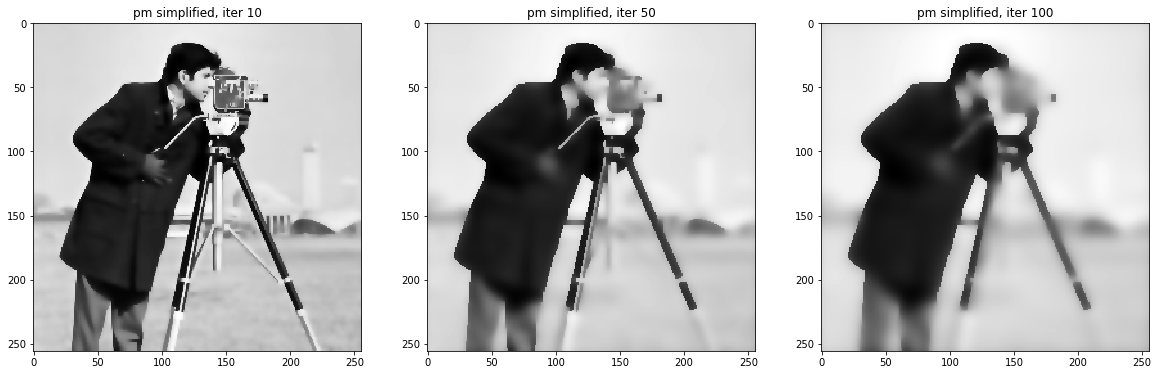

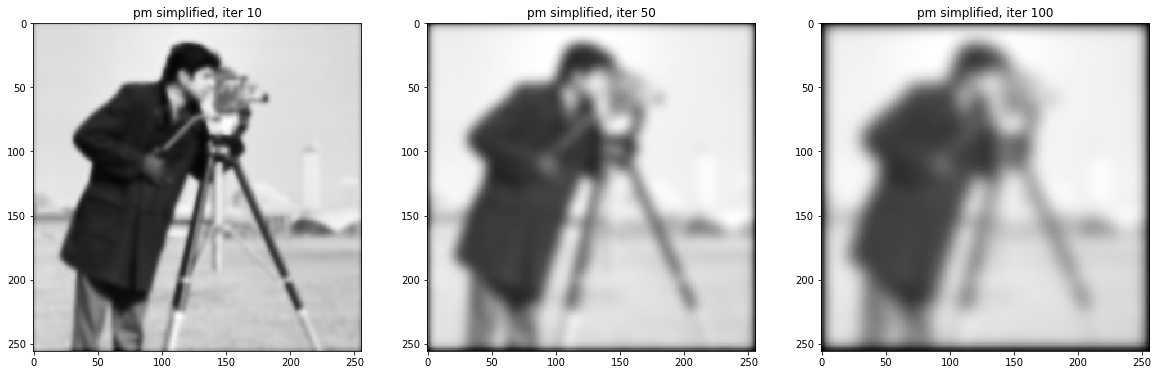

In [7]:
#show
show3(U_pms1,[10,50,100],'pm simplified')
show3(U_pms2,[10,50,100],'pm simplified')
show3(U_pms3,[10,50,100],'pm simplified')

#informations
print(f""" Les lignes correspondent à :
      K1 = {K1}
      K2 = {K2}
      K3 = {K3}""")

Le point d'inflexion de la fonction de conductivité est en K et permet de décider du seuil de renforcement/diminution 
des contours. \
En augmentant fortement K, on se rapproche donc du flou gaussien.

**INSTABILITE**

 dt = 4


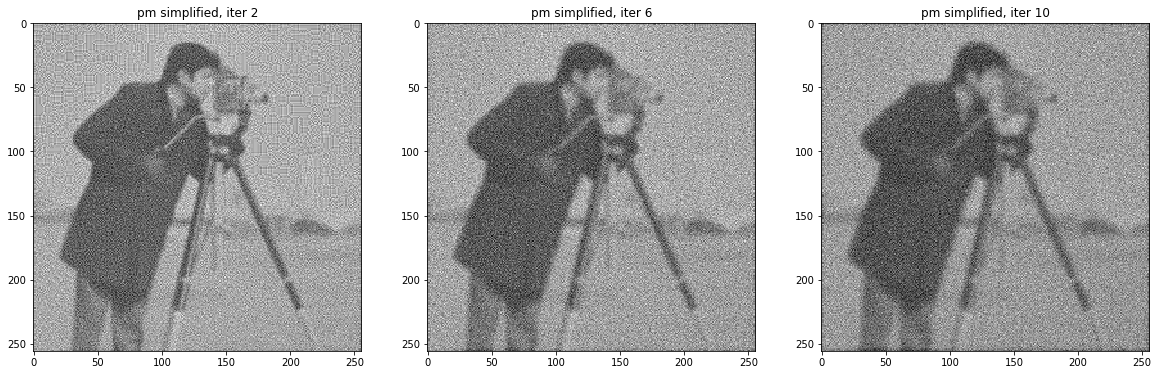

In [8]:
#raising dt
K = 20
dt = 4
n_iter = 11

#compute
u_pms4,U_pms4 = perona_malik_simplified(img,n_iter,dt,g,K)

#show
show3(U_pms4,[2,6,10],'pm simplified')
print(f""" dt = {dt}""")

Ce schéma est lui aussi instable

**EX3 : EDGE ENHANCING**

In [9]:
def edge_enhancing(img,n_iter,sigma,K):
    u,U = img,[]
    for i in range(n_iter):
        u = compute_edge_enhancing(u,sigma,K)
        U.append(u.copy())
    return u,U

def compute_edge_enhancing(u,sigma,K):
    n,m = u.shape
    #gradient in x,y wrt to another scale
    grad_x = ndimage.gaussian_filter1d(u,sigma,axis=0,order=1,mode='nearest',truncate=3)
    grad_y = ndimage.gaussian_filter1d(u,sigma,axis=1,order=1,mode='nearest',truncate=3)
    
    #norm
    norm_grad2 = grad_x**2 + grad_y**2 
    norm_grad = np.sqrt(norm_grad2)
    
    #applying conductivity function
    l2 = g_tukey(norm_grad,K)
    l1 = l2/5 
    
    #compute a,b and c
    [a,b,c] = [l1*grad_x**2+l2*grad_y**2, (l1-l2)*grad_x*grad_y, l2*grad_x**2+l1*grad_y**2] / (norm_grad2+EPS)
    
    #construct necessary matrices
    b_N_E = translate(b,-1,0) + translate(b,0,1)
    b_S_E = translate(b,1,0) + translate(b,0,1)
    b_S_W = translate(b,1,0) + translate(b,0,-1)
    b_N_W = translate(b,-1,0) + translate(b,0,-1)
    c_E_C = translate(c,0,1) + c
    c_W_C = translate(c,0,-1) + c
    a_S_C = translate(a,1,0) + a
    a_N_C = translate(a,-1,0) + a
    
    uNW = translate(u,-1,-1)
    uN  = translate(u,-1,0)
    uNE = translate(u,-1,1)
    uW  = translate(u,0,-1)
    uE  = translate(u,0,1)
    uSW = translate(u,1,-1)
    uS  = translate(u,1,0)
    uSE = translate(u,1,1)

    #compute u at time t+1
    u = u + dt * (0.25*(-b_N_E*uNE + b_S_E*uSE - b_S_W*uSW + b_N_W*uNW)
                  + 0.5*(c_E_C*uE + a_N_C*uN + c_W_C*uW  + a_S_C*uS
                        -(a_N_C + a_S_C + c_E_C + c_W_C)*u))
    return u

In [10]:
#image
img = imageio.imread('cameraman.jpg').astype(float)
#img = rgb2gray(imageio.imread('synpic45657.jpg').astype(float))
#img = imageio.imread('fingerprint-small.jpg').astype(float)

#parameters
sigma = 1
EPS = 0.01 #to avoid division by zero
K = 10
dt = 0.2
n_iter = 101

#compute
u_ee,U_ee = edge_enhancing(img,n_iter,sigma,K)

 Les lignes correspondent à :
      perona malik, tukey, K = 20
      edge enhancing K = 10


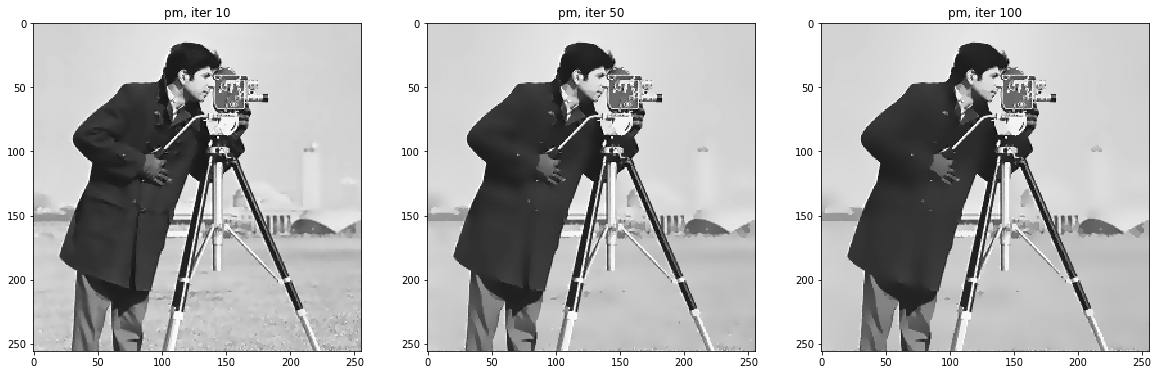

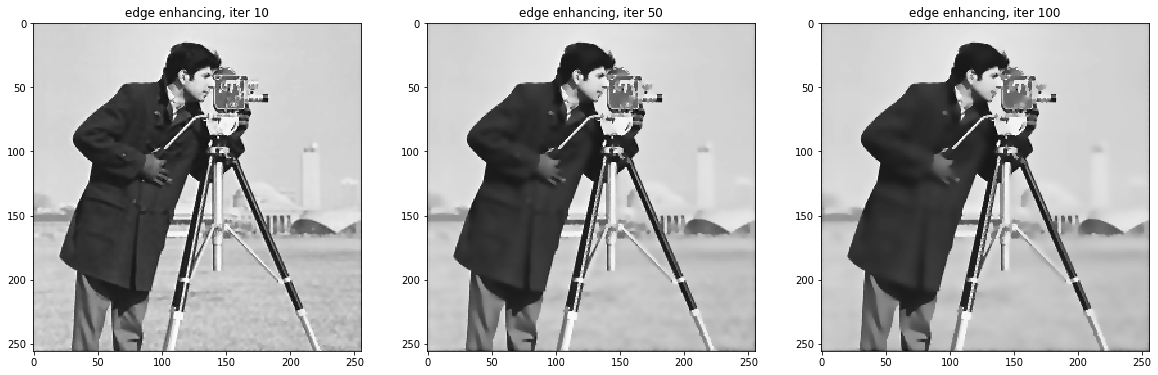

In [11]:
#show
show3(U_pm,[10,50,100],'pm')
show3(U_ee,[10,50,100],'edge enhancing')

#informations
print(f""" Les lignes correspondent à :
      perona malik, tukey, K = {20}
      edge enhancing K = {K}""")

Il est difficile de comparer les différentes méthodes avec les nombreux hyperparamètres (lorentz/tukey notamment).
On peut quand même observer que les contours restent globalement plus nets avec le edge enhancing qu'avec perona-malik.\
Cela se voit autour de la main, les plis des vêtements du caméraman ou encore l'arrière-plan avec le gratte-ciel et les variations du sol qui restent visibles là où chez perona-malik tout s'uniformise dès que la différence de niveau de gris est faible.
Néanmoins la caméra est étonnamment plus floutée avec le edge enhancing.


**INSTABILITE**

 dt = 1


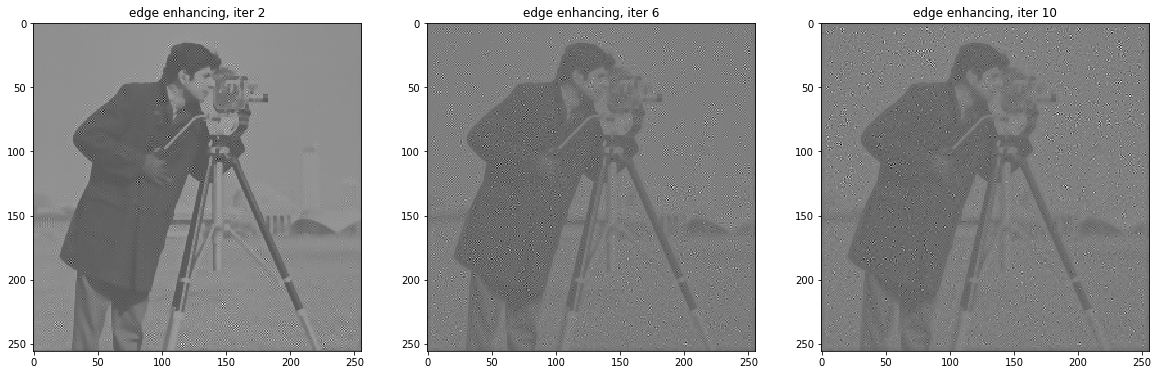

In [12]:
img = imageio.imread('cameraman.jpg').astype(float)
#raising dt
K = 20
dt = 1
n_iter = 11

#compute
u_ee2,U_ee2 = edge_enhancing(img,n_iter,dt,K)

#show
show3(U_ee2,[2,6,10],'edge enhancing')
print(f""" dt = {dt}""")

Ce schéma est également instable

**LIMITES**

In [13]:
#image
img = imageio.imread('fingerprint-small.jpg').astype(float)

#parameters
sigma = 1
K = 10
dt = 0.1
n_iter = 101

#compute
u_ee3,U_ee3 = edge_enhancing(img,n_iter,sigma,K)

edge enhancing K = 10


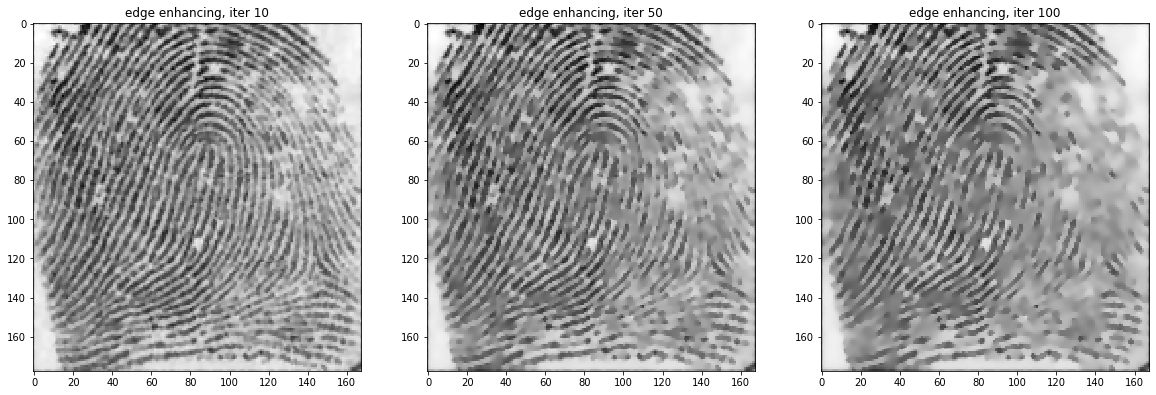

In [14]:
#show
show3(U_ee3,[10,50,100],'edge enhancing')
print(f"""edge enhancing K = {K}""")

La diffusion anisotropique du edge enhancing repose sur l'information d'orientation du gradient à une échelle suivante (image lissée).\
Dans le cas fingerprint ci-dessus, les gradients entre deux lignes proches se compensent après lissage de l'image.\
On ne peut pas non plus utiliser une échelle précédente lorsque l'image est bruitée comme dans notre cas fingerprint.
L'information d'orientation du gradient peut donc ne pas être efficace selon l'image.
Il faut une formulation pour prendre en compte la direction générale des contours

**EX4 : SCHEMA IMPLICITE**

In [15]:
def btcs(img,n_iter,alpha,gamma):
    u,U = img,[]
    for i in range(n_iter):
        u = compute_btcs(u,alpha,gamma)
        U.append(u.copy())
    return u,U

def compute_btcs(u,alpha,gamma):
    n,m = img.shape
    
    #matrix B
    B = u.reshape(-1)

    #matrix A with banded formulation
    A = np.zeros((2*n+1,B.shape[0]))
    A[0  , m: ] = -alpha
    A[n-1, 1: ] = -alpha
    A[n  , :  ] = gamma
    A[n+1, :-1] = -alpha
    A[-1 , :-m] = -alpha
    
    #care of right and left boundary, they are not supposed to be linked in 1d
    for i in range(0,B.shape[0],m):
        A[n-1,i] = 0       
        A[n+1,i+m-1] = 0
        
    #solve the system
    u = solve_banded((n,n),A,B)
    u = u.reshape(n,m)
    return u

In [16]:
#image
img = imageio.imread('cameraman.jpg').astype(float)

#parameters
c = 1
dt = 0.2
alpha = dt * c
gamma = 1+4*alpha
n_iter = 10

#compute
debut = time.time()
u_i,U_i = btcs(img,n_iter,alpha,gamma)
print(f'Temps de calcul : {time.time()-debut:.2f}s') 

Temps de calcul : 23.29s


 dt = 0.2


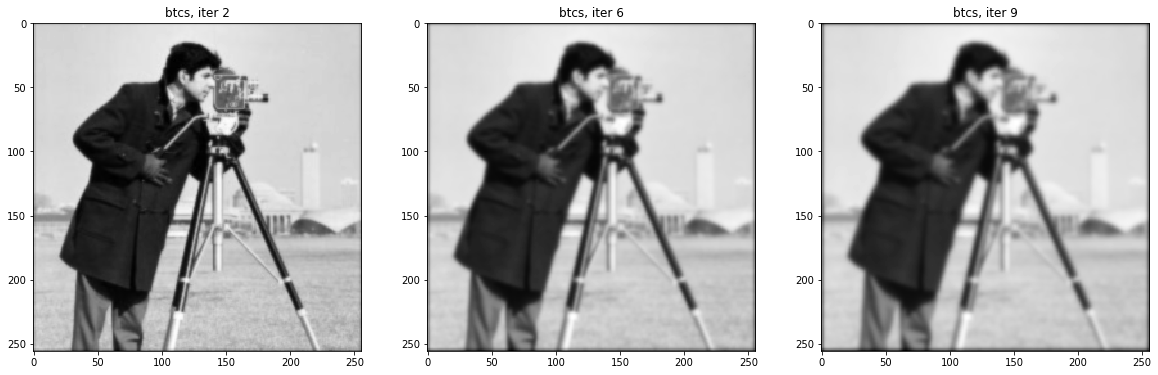

In [17]:
#show
show3(U_i,[2,6,9],'btcs')
print(f""" dt = {dt}""")

Le schéma BTCS (Backward Temporal Centered Space) nécessite d'inverser une matrice de taille (nx x ny,nx x ny) 
avec nx et ny les dimensions de l'image, couteux en mémoire et en temps même avec des fonctions optimisées reposant sur 
la sparsité de la matrice. (5 diagonales en 2d)

**CAS FINGERPRINT, IMAGE CARRE OU NON**

In [18]:
#image
img = imageio.imread('fingerprint-small.jpg').astype(float)
#compute
debut = time.time()
u_i,U_i = btcs(img,n_iter,alpha,gamma)
print(f'Temps de calcul : {time.time()-debut:.2f}s') 

Temps de calcul : 3.70s


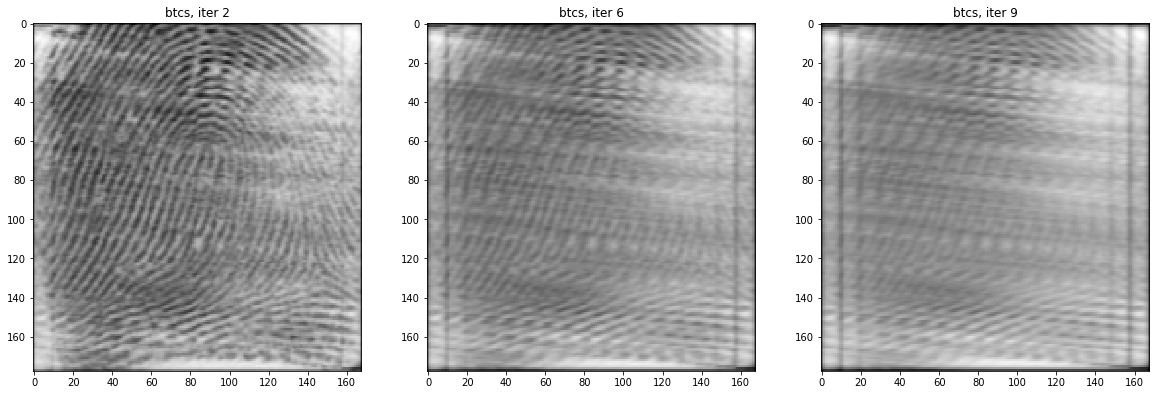

In [19]:
#show
show3(U_i,[2,6,9],'btcs')

Il y a un léger problème dans l'implémentation. Cela ne fonctionne par sur les images non carrées

In [20]:
#image
img = imageio.imread('fingerprint-small.jpg').astype(float)[0:168,0:168]
#compute
debut = time.time()
u_i,U_i = btcs(img,n_iter,alpha,gamma)
print(f'Temps de calcul : {time.time()-debut:.2f}s') 

Temps de calcul : 2.84s


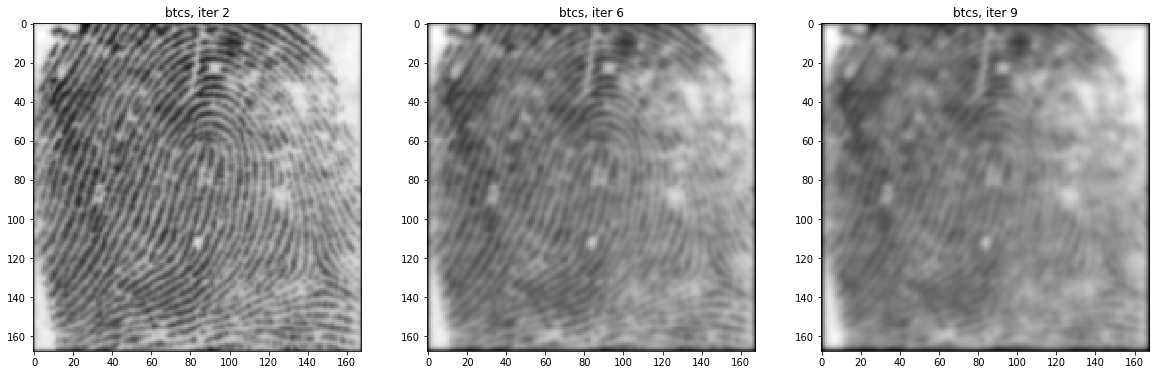

In [21]:
#show
show3(U_i,[2,6,9],'btcs')

**STABILITE**

In [22]:
#image
img = imageio.imread('cameraman.jpg').astype(float)

#raising dt
c = 1
dt = 2
alpha = dt * c
gamma = 1+4*alpha
n_iter = 8

#compute
debut = time.time()
u_i2,U_i2 = btcs(img,n_iter,alpha,gamma)
print(f'Temps de calcul : {time.time()-debut:.2f}s') 


Temps de calcul : 14.98s


 dt = 2


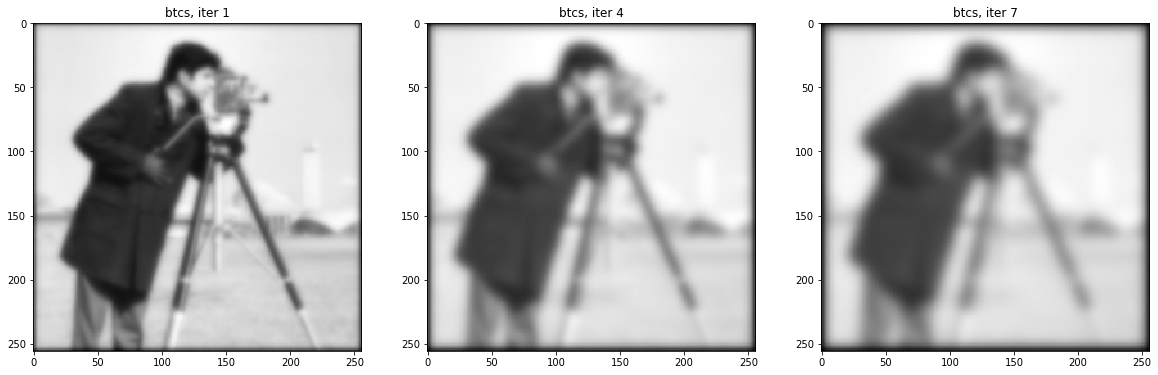

In [23]:
#show
show3(U_i2,[1,4,7],'btcs')
print(f""" dt = {dt}""")

Le schéma implicite est par contre toujours stable